# **Objective:**
**The classification goal is to predict the likelihood of a liability customer buying personal
loans.**

![alt text](https://cdn.studentloanhero.com/wp-content/uploads/difference-between-subsidized-and-unsubsidized-loans-1-640x300.jpg)

#### **List of task in the Project:**

*   Study the data distribution in each attribute, share your findings
*   Target column distribution
*   Split the data into training and test set in the ratio of 70:30
*   Use different classification models (Logistic, K-NN and Naïve Bayes) 
    to   predict the likelihood of a customer buying personal loans
*   Print the confusion matrix for all the above models
*   Reasoning on which is the best model in this case and why it performs
    better







**Let's start of with import necessary libraries**

In [0]:
import pandas as pd ### for dataframe handling
import numpy as np ##array handling
import matplotlib.pyplot as plt ## plotting
%matplotlib inline
import seaborn as sns ## plotting
from statsmodels.stats.outliers_influence import variance_inflation_factor  ## VIF calculations
from imblearn.over_sampling import SMOTE ## to work on imbalance dataset
from imblearn.pipeline import make_pipeline ## create pipelin
from sklearn.metrics import accuracy_score ## accuracy calculations
from sklearn.metrics import precision_score, recall_score, confusion_matrix ## model evaluation parameters
from sklearn.metrics import f1_score, roc_auc_score, roc_curve ##some more model evaluation parameters
from sklearn.model_selection import GridSearchCV ## gridsearch 
from sklearn.model_selection import train_test_split ### traintest split object
from pylab import rcParams  ##plotiing
import warnings
warnings.filterwarnings("ignore")

**Let's call out some of helper functions which will be used further**

In [0]:
def quick_report(df):

  """ 
  This function will give a quick overview about dataset shape, dtypes, column names and NULL value count
  
  """
  print('Data Types:')
  print(df.dtypes)
  print('Rows and Columns:')
  print(df.shape)
  print('Column Names:')
  print(df.columns)
  print('Null Values:')
  print(df.apply(lambda x: sum(x.isnull()) / len(df)))

In [0]:
def transform_minmaxscaler(x):
  """
  This function will apply minmax transformation on the column input and will return the transformed version of the input parameter 
  """
  to_scaled=pd.DataFrame(x)
  from sklearn.preprocessing import MinMaxScaler 
  scaler=MinMaxScaler(copy=False)
  to_scaled_minmax = scaler.fit_transform(to_scaled)
  to_scaled_minmax=pd.DataFrame(to_scaled_minmax,columns=[to_scaled.columns])
  return to_scaled_minmax

In [0]:
def generate_model_report(y_actual, y_predicted):
    """
    Calculate model evaluation parameters with input as actual Y column and predicted Y column
    """
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass 

In [0]:
def run_my_model_log(data,X,y):
    """
    This function will run logistic regression model with the input as dataframe, X and Y. 
    It will split the data into train and test with test size=0.3
    It will give the proportion of 1 and 0 in the complete dataframe, trainset and testset
    It will also calculate the model evaluation parameters and Confusion matrix
    """
    print('\033[1m Following results are for Logistic Regression \033[0;0m')

    print("\n")
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    from sklearn.linear_model import LogisticRegression
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    # Fit the model on train
    model = LogisticRegression(solver="liblinear")
    model.fit(x_train, y_train)
    #predict on test
    y_predict = model.predict(x_test)

    model_score = model.score(x_test, y_test)
    model_score_train=metrics.accuracy_score(y_train,model.predict(x_train))
    model_recall_score=metrics.recall_score(y_test, y_predict, average='binary')
    model_precision_score=metrics.precision_score(y_test, y_predict, average='binary')
    model_f1_score=metrics.f1_score(y_test, y_predict, average='binary')
    

    print("Original PL True Values    : {0} ({1:0.2f}%)".format(len(data.loc[data['Personal Loan'] == 1]), (len(data.loc[data['Personal Loan'] == 1])/len(data.index)) * 100))
    print("Original PL False Values   : {0} ({1:0.2f}%)".format(len(data.loc[data['Personal Loan'] == 0]), (len(data.loc[data['Personal Loan'] == 0])/len(data.index)) * 100))
    print("")
    print("Training PL True Values    : {0} ({1:0.2f}%)".format(y_train.sum()[0], (y_train.sum()[0]/len(y_train)) * 100))
    print("Training PL False Values   : {0} ({1:0.2f}%)".format((len(y_train)-(y_train.sum()))[0], ((len(y_train)-(y_train.sum()))[0]/len(y_train)) * 100))
    print("")
    print("Test PL True Values        : {0} ({1:0.2f}%)".format(y_test.sum()[0], (y_test.sum()[0]/len(y_test)) * 100))
    print("Test PL False Values       : {0} ({1:0.2f}%)".format((len(y_test)-(y_test.sum()))[0], ((len(y_test)-(y_test.sum()))[0]/len(y_test)) * 100))
    print("")
    
    print('The Model Score is {}'.format(round(model_score*100,2)))
    print('The Model Score on train set is {}'.format(round(model_score_train*100,2)))
    print('The Recall Score for the Model is {}'.format(round(model_recall_score*100,2)))
    print('The Precision Score for the Model is {}'.format(round(model_precision_score*100,2)))
    print('The F1 Score for the Model is {}'.format(round(model_f1_score*100,2)))
    
    
    print('\n')

    
    cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
    plt.figure(figsize = (7,5))
    return sns.heatmap(df_cm, annot=True,fmt='g')

In [0]:
def run_my_model_knn(X,y,k):
    """
    This function will run KNN algorithm on the data.
    """
    print('\033[1m Following results are for KNN  \033[0;0m')
    print("\n")
    from sklearn.neighbors import KNeighborsClassifier
    from scipy.stats import zscore
    from sklearn import metrics
    # convert the features into z scores 
    XScaled  = X.apply(zscore)  # convert all attributes to Z scale 
    #XScaled.describe()
    X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size=0.30, random_state=1)
    kkn_model = KNeighborsClassifier(n_neighbors=  k, weights = 'distance' )
    kkn_model.fit(X_train,y_train.values.ravel())
    model_score_train=metrics.accuracy_score(y_train,kkn_model.predict(X_train))
    print('The Model Accuracy Score on train set is {}'.format(round(model_score_train,2)))
    print("\n")
    y_predict=kkn_model.predict(X_test)
    generate_model_report(y_test,y_predict)
    print("\n")
    conf_mat=pd.crosstab(y_predict, y_test['Personal Loan'], rownames=['Predicted'], colnames=['Actual'])
    print('Confusion Matrix')
    print("\n")
    print(conf_mat)


In [0]:
def run_my_model_nb(X,y):
    print('\033[1m Following results are for Navie Bayes Classifier \033[0;0m')
    print("\n")
    from sklearn.naive_bayes import GaussianNB
    from sklearn import metrics
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train.values.ravel())
    model_score_train=metrics.accuracy_score(y_train,nb_model.predict(X_train))
    print('The Model Accuracy Score on train set is {}'.format(round(model_score_train,2)))
    print("\n")

    y_predict=nb_model.predict(X_test)
    generate_model_report(y_test,y_predict)
    print("\n")
    conf_mat=pd.crosstab(y_predict, y_test['Personal Loan'], rownames=['Predicted'], colnames=['Actual'])
    print('Confusion Matrix')
    print("\n")
    print(conf_mat)


#### **Let's import the dataframe**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
path='/content/drive/My Drive/GL Project/Bank_Personal_Loan_Modelling.csv'
data=pd.read_csv(path)

In [11]:
data.head()
## dataframe is been successfully loaded into the notebook!!!

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [0]:
quick_report(data)

Data Types:
ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object
Rows and Columns:
(5000, 14)
Column Names:
Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')
Null Values:
ID                    0.0
Age                   0.0
Experience            0.0
Income                0.0
ZIP Code              0.0
Family                0.0
CCAvg                 0.0
Education             0.0
Mortgage              0.0
Personal Loan         0.0
Securities Account    0.

The dataframe has 5000 observations and 14 columns. It doesn't contain any NULL values. 

In [12]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


Highest age of the individual which was part of the campaign is 67 and lowest is 23. Distribution for CCAvg and Income attritbutes is skewwed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efea6c27e10>,
      dtype=object)

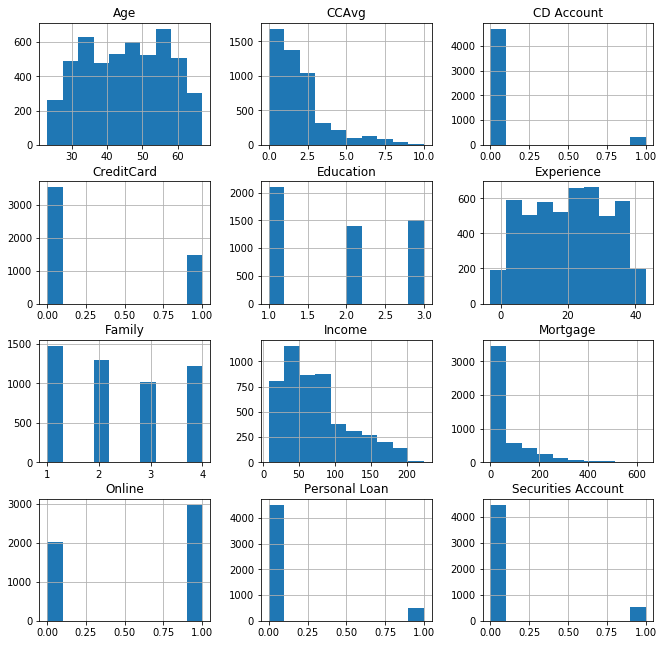

In [0]:
cols = [col for col in data.columns if col not in ['ID', 'ZIP Code']]
df = data[cols]
df[df.dtypes[(df.dtypes=="float64")|(df.dtypes=="int64")]
                        .index.values].hist(figsize=[11,11])

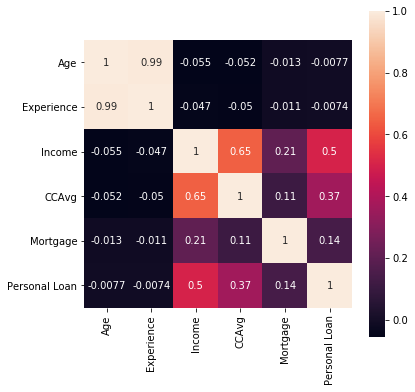

In [0]:
data2=data[['Age','Experience', 'Income','CCAvg', 'Mortgage', 'Personal Loan']]
fig_dims = (6,6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data2.corr(),annot=True,square=True,ax=ax)

In [0]:
cat= ['Family','Education','Securities Account',
       'CD Account', 'Online', 'CreditCard','Personal Loan']
for col in cat:
  print(data[col].value_counts(normalize=True)*100)

1    29.44
2    25.92
4    24.44
3    20.20
Name: Family, dtype: float64
1    41.92
3    30.02
2    28.06
Name: Education, dtype: float64
0    89.56
1    10.44
Name: Securities Account, dtype: float64
0    93.96
1     6.04
Name: CD Account, dtype: float64
1    59.68
0    40.32
Name: Online, dtype: float64
0    70.6
1    29.4
Name: CreditCard, dtype: float64
0    90.4
1     9.6
Name: Personal Loan, dtype: float64


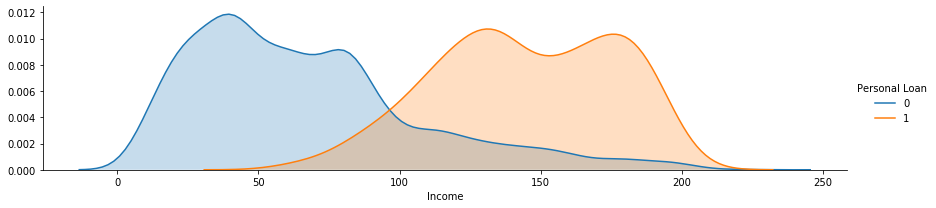

In [0]:
fig = sns.FacetGrid(data,hue='Personal Loan',aspect=4)
fig.map(sns.kdeplot,'Income',shade=True)
fig.add_legend()

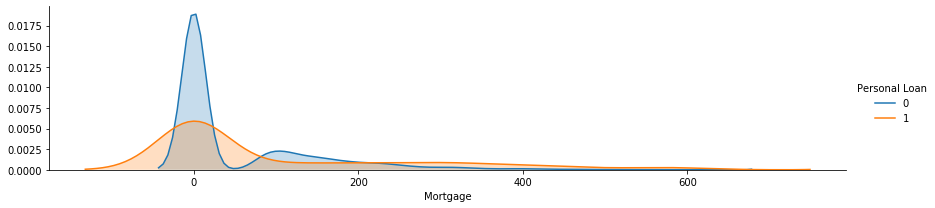

In [0]:
fig = sns.FacetGrid(data,hue='Personal Loan',aspect=4)
fig.map(sns.kdeplot,'Mortgage',shade=True)
fig.add_legend()

#### **1. Observations on Independent variables**


*   As mentioned earlier, distributions for CCAvg, Income and Mortgage is skewwed to the right meanning we might need to apply some transformation on the columns
*   Dataframe contains highest number of customers who are bachelors followed by customers with family of 2
*   Close to 40% of the customer base is Undergraduate followed by approx equal number of Graduate and Professionals.
*   Age and Experience are highly correlated to each other. 
*   Income is correlated with the target variable also, Higher the Income, higher is the chance of opting for Personal Loan
*   50% of the base have zero Mortgage
*   90% of customers do not have security account with the bank
*   94% of the customer don't have cash deposit account with the bank
*   Siginificant number of inidividuals prefer Online Banking
*   10% of the customers are holding Credit Card














#### **2. Observations on Target variable**


10% of the customer base have opted for the Personal Loan while the rest 90% have not shown interest in the campaign indicating that the distribution of the class is not balanced. In such cases when we try to build the model where the target class is imbalance, the model tends to predict the majority class more often compared to the minority class. To overcome the Imbalanced problem we will need to use sampling technique. 



#### Standardize the variables

In [0]:
to_scaled_minmax=transform_minmaxscaler(data[['Income','CCAvg','Mortgage']])

In [14]:
X=data[['Age','Experience','Family','Education','Securities Account',
       'CD Account', 'Online', 'CreditCard']]
y=data[['Personal Loan']]       

X=pd.concat([X,to_scaled_minmax],axis=1,ignore_index=True)

X.columns=['Age','Experience','Family','Education','Securities Account',
       'CD Account', 'Online', 'CreditCard','Income','CCAvg','Mortgage']

X.shape,y.shape       

((5000, 11), (5000, 1))

### **Checking VIF among the predictors**

In [0]:
VF = X.assign(const=1)
pd.Series([variance_inflation_factor(VF.values, i) 
               for i in range(VF.shape[1])], 
              index=VF.columns)

Age                    93.675767
Experience             93.577470
Family                  1.034041
Education               1.114846
Securities Account      1.137176
CD Account              1.329842
Online                  1.039584
CreditCard              1.107884
Income                  1.858986
CCAvg                   1.728938
Mortgage                1.051253
const                 452.051398
dtype: float64

In [15]:
#Let's drop Experience from the data and recalculate the VIF
X=X.drop('Experience',axis=1)
VF = X.assign(const=1)
pd.Series([variance_inflation_factor(VF.values, i) 
               for i in range(VF.shape[1])], 
              index=VF.columns)

Age                    1.008374
Family                 1.032291
Education              1.044019
Securities Account     1.136822
CD Account             1.328768
Online                 1.039524
CreditCard             1.107883
Income                 1.854712
CCAvg                  1.723904
Mortgage               1.051253
const                 34.213475
dtype: float64

#### **Running 1st Model in Logistic Regression for all variables except Experience which is highly correlated with Age**

 Following results are for Logistic Regression 
Original PL True Values    : 480 (9.60%)
Original PL False Values   : 4520 (90.40%)

Training PL True Values    : 331 (9.46%)
Training PL False Values   : 3169 (90.54%)

Test PL True Values        : 149 (9.93%)
Test PL False Values       : 1351 (90.07%)

The Model Score is 94.07
The Model Score on train set is 94.86
The Recall Score for the Model is 48.99
The Precision Score for the Model is 84.88
The F1 Score for the Model is 62.13




/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


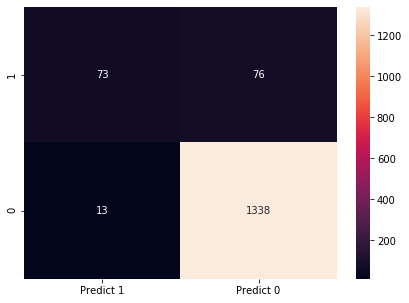

In [0]:
run_my_model_log(data,X,y)

In [0]:
run_my_model_knn(X,y,5)

 Following results are for KNN  


The Model Accuracy Score on train set is 1.0


Accuracy =  0.9586666666666667
Precision =  0.9484536082474226
Recall =  0.6174496644295302
F1 Score =  0.7479674796747967


Confusion Matrix


Actual        0   1
Predicted          
0          1346  57
1             5  92


In [0]:
run_my_model_nb(X,y)

 Following results are for Navie Bayes Classifier 


The Model Accuracy Score on train set is 0.89


Accuracy =  0.8746666666666667
Precision =  0.40669856459330145
Recall =  0.5704697986577181
F1 Score =  0.4748603351955307


Confusion Matrix


Actual        0   1
Predicted          
0          1227  64
1           124  85


### **Trying to improve model accuracy using Feature Selection Method**

##### Using Recursive Feature Elimination method for Feature Selection. We will select top 5 features

In [0]:
X.columns

Index(['Age', 'Family', 'Education', 'Securities Account', 'CD Account',
       'Online', 'CreditCard', 'Income', 'CCAvg', 'Mortgage'],
      dtype='object')

In [0]:
df=pd.concat([X,y],axis=1,ignore_index=True)

In [0]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
array = df.values
X = array[:,0:10]
Y = array[:,10]
# feature extraction
model = LogisticRegression(solver="liblinear")
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [False False  True False  True False  True  True  True False]
Feature Ranking: [6 4 1 2 1 3 1 1 1 5]


#### **Top five features are 'Education', 'CD Account','CreditCard', 'Income', 'CCAvg'**


In [0]:
X=X[[ 'Education', 'CD Account','CreditCard', 'Income', 'CCAvg']]

##### **Let's re-run the models on the new dataset**

 Following results are for Logistic Regression 


Original PL True Values    : 480 (9.60%)
Original PL False Values   : 4520 (90.40%)

Training PL True Values    : 331 (9.46%)
Training PL False Values   : 3169 (90.54%)

Test PL True Values        : 149 (9.93%)
Test PL False Values       : 1351 (90.07%)

The Model Score is 94.07
The Model Score on train set is 94.57
The Recall Score for the Model is 47.65
The Precision Score for the Model is 86.59
The F1 Score for the Model is 61.47




/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


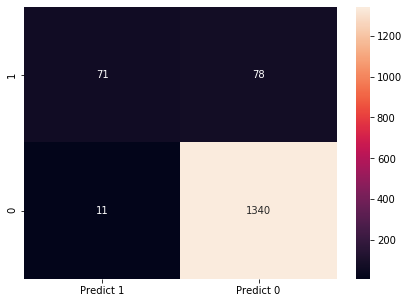

In [0]:
run_my_model_log(data,X,y)

In [0]:
run_my_model_knn(X,y,5)

 Following results are for KNN  


The Model Accuracy Score on train set is 1.0


Accuracy =  0.9626666666666667
Precision =  0.8907563025210085
Recall =  0.7114093959731543
F1 Score =  0.7910447761194029


Confusion Matrix


Actual        0    1
Predicted           
0          1338   43
1            13  106


In [0]:
run_my_model_nb(X,y)

 Following results are for Navie Bayes Classifier 


The Model Accuracy Score on train set is 0.9


Accuracy =  0.8853333333333333
Precision =  0.4371584699453552
Recall =  0.5369127516778524
F1 Score =  0.4819277108433735


Confusion Matrix


Actual        0   1
Predicted          
0          1248  69
1           103  80


##### **Model Accuracy for all three model is excellent and pretty close to trainset accuracy too, indicating that our model is not overfitting. But we can't say that these is the best model because, the Recall score is low indicating that we are making significant number of FALSE NEGATIVE predictions. Our final objective is to identify the individuals who will buy Personal Loan. Due to the Imbalanced ratio of the target class, our model is classifying majority of the TRUE cases as Negative.** 
##### **In the campaign we can make few FALSE POSITIVE predictions and communicate a customer who is not interested in Personal Loan but our FALSE NEGATIVE cases should be very minimum i.e. the customer who have high propensity of taking Personal Loan should not be missed, which means we need to increase Recall. At the same time Precision shouldn't be very low. We need to use OVERSAMPLING technique to overcome this problem of IMBALANCED set**
#### **We will use SMOTE**

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1)

#### **Creating Grid search pipeline to obtain optimal value of the SMOTE ratio**

Best parameters : {'smote__ratio': 0.531578947368421}


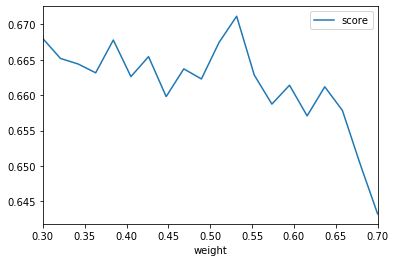

In [0]:
pipe = make_pipeline(
    SMOTE(),
    LogisticRegression(solver="liblinear")
)

weights = np.linspace(0.3, 0.7, 20)

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__ratio': weights
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(X_train, Y_train.values.ravel())

print("Best parameters : %s" % grid_result.best_params_)
weight_f1_score_df = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                                   'weight': weights })
weight_f1_score_df.plot(x='weight')

##### **The optimum value of SMOTE ratio from the above grid search is 0.531578947368421 ~0.5**

In [0]:
pipe = make_pipeline(
    SMOTE(ratio=0.531578947368421),
    LogisticRegression(solver="liblinear")
)

pipe.fit(X_train, Y_train)

Y_Test_Pred = pipe.predict(X_test)

generate_model_report(Y_test, Y_Test_Pred)

conf_mat=pd.crosstab(Y_Test_Pred, Y_test['Personal Loan'], 
            rownames=['Predicted'], colnames=['Actual'])
print(conf_mat)

Accuracy =  0.9166666666666666
Precision =  0.56
Recall =  0.7516778523489933
F1 Score =  0.6418338108882522
Actual        0    1
Predicted           
0          1263   37
1            88  112


##### **Following functions will run Logistic Regression, KNN and Navie Bayes Classifier algorithm. We need to feed the sampling ratio as a input**

In [0]:
def run_smote_model_log(X,y,z):
    print('\033[1m Following results are for Logistic Regression using SMOTE \033[0;0m')
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1)
    sm = SMOTE(random_state=12,ratio=z)
    x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)
    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics
    # Fit the model on train
    model_sm = LogisticRegression(solver="liblinear")
    model_sm.fit(x_train_res, y_train_res.ravel())

    model_score_train=metrics.accuracy_score(y_train_res,model_sm.predict(x_train_res))
    print('The Model Accuracy Score on train set is {}'.format(round(model_score_train,2)))
    print("\n")

    #predict on test
    y_predict = model_sm.predict(X_test)
    generate_model_report(Y_test,y_predict)

    print("\n")
    conf_mat=pd.crosstab(y_predict, Y_test['Personal Loan'], rownames=['Predicted'], colnames=['Actual'])
    print('\033[1m Confusion Matrix \033[0;0m')
    print("\n")
    print(conf_mat)



In [0]:
def run_smote_model_knn(X,y,z,k):
    print('\033[1m Following results are for KNN using SMOTE \033[0;0m')
    from sklearn.neighbors import KNeighborsClassifier
    from scipy.stats import zscore
    from sklearn import metrics
    # convert the features into z scores 
    XScaled  = X.apply(zscore)  # convert all attributes to Z scale 
    #XScaled.describe()
    X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size=0.30, random_state=1)
    sm = SMOTE(random_state=12,ratio=z)
    x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    kkn_model = KNeighborsClassifier(n_neighbors=  k, weights = 'distance' )
    kkn_model.fit(x_train_res, y_train_res)
    model_score_train=metrics.accuracy_score(y_train_res,kkn_model.predict(x_train_res))
    print('The Model Accuracy Score on train set is {}'.format(round(model_score_train,2)))
    print("\n")
    y_predict=kkn_model.predict(X_test)
    generate_model_report(y_test,y_predict)
    print("\n")
    conf_mat=pd.crosstab(y_predict, y_test['Personal Loan'], rownames=['Predicted'], colnames=['Actual'])
    print('\033[1m Confusion Matrix \033[0;0m')
    print("\n")
    print(conf_mat)


In [0]:
def run_smote_model_nb(X,y,z):
    print('\033[1m Following results are for Navie Bayes Classifier using SMOTE \033[0;0m')
    from sklearn.naive_bayes import GaussianNB
    from sklearn import metrics
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    sm = SMOTE(random_state=12,ratio=z)
    x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    nb_model = GaussianNB()
    nb_model.fit(x_train_res, y_train_res.ravel())
    model_score_train=metrics.accuracy_score(y_train_res,nb_model.predict(x_train_res))
    print('The Model Accuracy Score on train set is {}'.format(round(model_score_train,2)))
    print("\n")

    y_predict=nb_model.predict(X_test)
    generate_model_report(y_test,y_predict)
    print("\n")
    conf_mat=pd.crosstab(y_predict, y_test['Personal Loan'], rownames=['Predicted'], colnames=['Actual'])
    print('\033[1m Confusion Matrix \033[0;0m')
    print("\n")
    print(conf_mat)


In [20]:
run_smote_model_log(X,y,0.5)

 Following results are for Logistic Regression using SMOTE 
The Model Accuracy Score on train set is 0.89


Accuracy =  0.916
Precision =  0.5566502463054187
Recall =  0.7583892617449665
F1 Score =  0.6420454545454546


 Confusion Matrix 


Actual        0    1
Predicted           
0          1261   36
1            90  113


In [21]:
run_smote_model_knn(X,y,0.5,5)

 Following results are for KNN using SMOTE 
The Model Accuracy Score on train set is 1.0


Accuracy =  0.9573333333333334
Precision =  0.7575757575757576
Recall =  0.8389261744966443
F1 Score =  0.7961783439490445


 Confusion Matrix 


Actual        0    1
Predicted           
0          1311   24
1            40  125


In [24]:
run_smote_model_nb(X,y,0.5)

 Following results are for Navie Bayes Classifier using SMOTE 
The Model Accuracy Score on train set is 0.85


Accuracy =  0.868
Precision =  0.4
Recall =  0.6577181208053692
F1 Score =  0.4974619289340102


 Confusion Matrix 


Actual        0   1
Predicted          
0          1204  51
1           147  98


### **From the above functions outputs for 3 different model, it is pretty evident that SMOTE's application on the problem set has significantly improved model performance. Considering the problem statement, the ideal model should be with high recall**
### **Looking at the results for the three models, Navie Bayes has not performed well enough. On the other hand, KNN and Logistic have performed very well.**
### **Among Logistic and KNN, KNN evaluation results are very significant compared to that of Logistic reg and is the best model. Reason being the Overall accuracy of KNN is 96% with Recall of 84% which says 'out of the total 1's predicted by the model, 84% of them are 1's in actual case'. The F1 score of the model is 80% which is excellent**

##                              **KNN WIN's**

